In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
plt.style.use('default')
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF, PCA
from sklearn.manifold import Isomap
import requests
stopwords_list = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
stopwords = set(stopwords_list.decode().splitlines()) 



# Aula 16: Clustering
**Objetivo: ao fim desta aula, o aluno usará e interpretará técnicas de clustering para dividir coleções em conjuntos mais simples de analisar**

# Exercício 1
*Objetivo: identificar clusters em uma figura*

A figura abaixo mostra o plot de duas dimensões em um dataset.
1. Como os elementos desse dataset parecem se organizar?
1. Marque na figura quais são as “sub-estruturas” que organizam os elementos do dataset.

(300, 2)


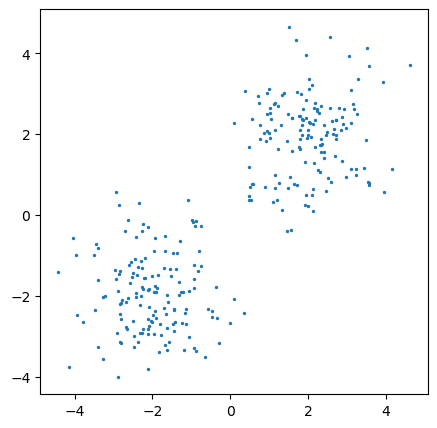

In [2]:
from sklearn.datasets import make_blobs
x,y = make_blobs(n_samples=300, n_features=2, centers=[[-2,-2],[2,2]])
print (x.shape)
plt.figure(figsize=(5,5))
plt.scatter(x[:,0], x[:,1], s=2)
#plt.savefig('clusters.png')
plt.show()

# Exercício 2
*Objetivo: usar a API do scikit-learn para encontrar clusters com K-Means*

K-Means é um algoritmo de clusterização. A ideia de K-Means é que cada cluster é definido por um centro (são k centros). Um ponto pertence ao cluster do qual ele mais se aproxima do centro. Na etapa de `fit`, k-means iterativamente move cada centro para o ponto médio do cluster que ele está definindo, até que ele pare de se mover ou até que um máximo de iterações seja atingido.

No seu notebook, analise o código que exemplifica o uso de k-means. Após a execução, verifique:
1. Qual é o conteúdo da variável x_?
1. Qual é o conteúdo da variável means_?
1. Qual é o conteúdo da variável labels_?
1. Como os clusters são mostrados na figura que foi gerada?
1. O que acontece se aumentamos o número de clusters do dataset, na função `make_blobs` do exercício 1?
1. O que acontece se aumentamos o número de clusters a serem detectados pelo k-menas (`n_clusters=k`)?
1. Faça uma figura em que há pontos distribuídos por 3 blobs e que foram clusterizados em um k-means com k=8.



In [10]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
x_ = kmeans.fit_transform(x)
means_ = kmeans.cluster_centers_
labels_ = kmeans.labels_

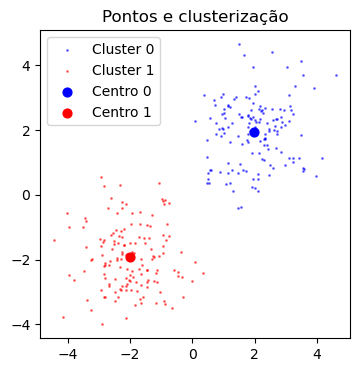

In [11]:
xp = np.array([x[i,:] for i in range(len(labels_)) if labels_[i]==0])
xn = np.array([x[i,:] for i in range(len(labels_)) if labels_[i]==1])
plt.figure(figsize=(4,4))
plt.scatter(xp[:,0], xp[:,1], s=1, c='b', alpha=0.5, label='Cluster 0')
plt.scatter(xn[:,0], xn[:,1], s=1, c='r', alpha=0.5, label='Cluster 1')
plt.scatter(means_[0,0], means_[0,1], s=40, c='b', label='Centro 0')
plt.scatter(means_[1,0], means_[1,1], s=40, c='r', label='Centro 1')
plt.title('Pontos e clusterização')
plt.legend()
plt.show()

# Exercício 3
*Objetivo: interpretar clusters encontrados com K-Means*

No código abaixo, realizamos uma clusterização dos reviews do IMDB usando K-Means.

1. Analise o código e discuta:
   1. O que cada entrada de K-Means representa?
   1. O que cada dimensão das entradas de K-Means representa?
   1. Por que é necessário usar PCA para gerar a figura?
   1. Por que os clusters se sobrepõem na figura final?

1. Analisando as contagens de palavras em cada tópico, identifique:
   1. Há claramente diferentes perfis de públicos?
   1. Há clusters que têm poucas pessoas?
   1. O que muda nos resultados quando mudamos o valor de K?

1. Modifique o código para que o processo de análise use as projeções em tópicos dos documentos (NMF), e não mais os documentos em si. Você consegue visualizar mudanças?


In [19]:
df = pd.read_csv('./datasets/IMDB Dataset.csv').sample(2000)
adhoc_stopwords = set(("good time 10 lost great bad".split()))
vectorizer = CountVectorizer(binary=True, stop_words=set.union(stopwords, adhoc_stopwords), max_features=1000, max_df=0.4, ngram_range=(1,2))
X = vectorizer.fit_transform(list(df['review']))
print(X.shape)
projecao = PCA(n_components=2)
y = projecao.fit_transform(X.toarray())
# plt.figure(figsize=(4,4))
# plt.scatter(y[:,0], y[:,1], s=1, c='b', alpha=0.5)
# plt.title('Projeção da distribuição de documentos')
# plt.ylabel('Componente 2')
# plt.xlabel('Componente 1')
# plt.legend()
# plt.show()

(2000, 1000)


(284, 2)
(53, 2)
(1333, 2)
(1, 2)
(31, 2)
(298, 2)


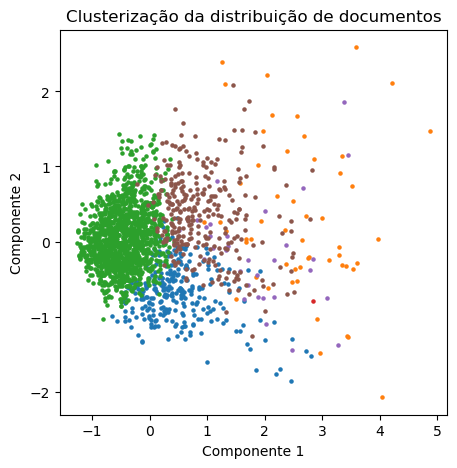

In [20]:
n_clusters = 6
colors = list(mcolors.TABLEAU_COLORS)
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(X)
c = kmeans.labels_
plt.figure(figsize=(5,5))
for k in range(n_clusters):
    yc = np.array([ [y[i,0], y[i,1]] for i in range(len(c)) if c[i]==k ])
    print(yc.shape)
    plt.scatter(yc[:,0], yc[:,1], s=5, c=colors[k], label=str(k))
plt.title('Clusterização da distribuição de documentos')
plt.ylabel('Componente 2')
plt.xlabel('Componente 1')
plt.show()


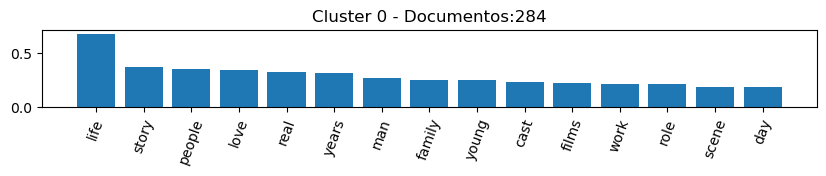

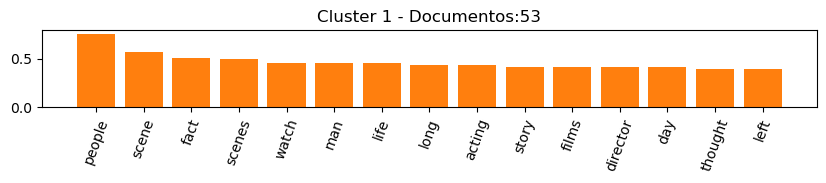

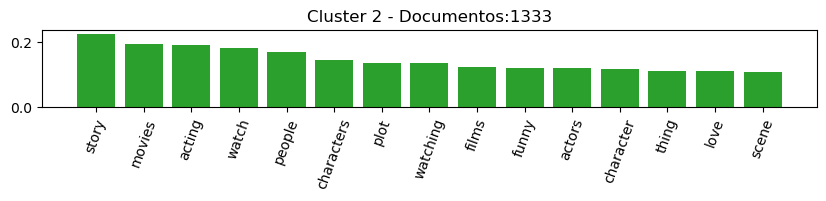

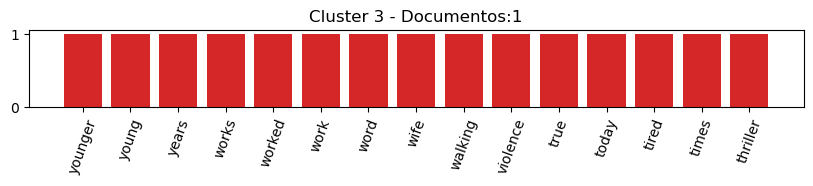

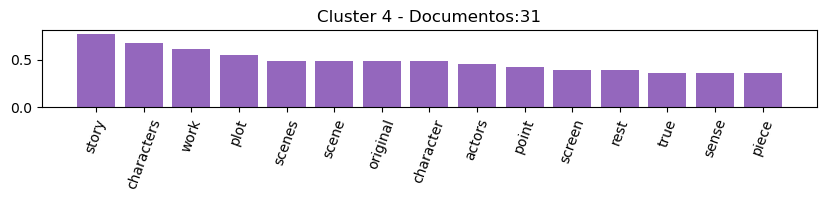

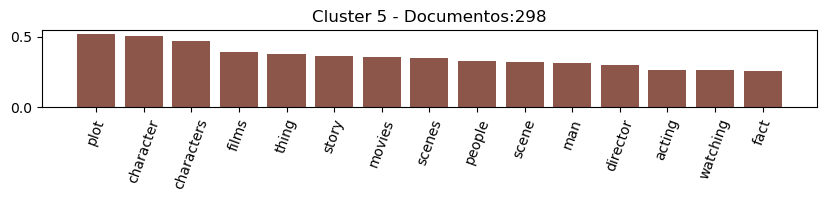

In [21]:
# Calcular soma de DF por cluster
for k in range(n_clusters):
    x_ = np.mean(X[c==k,:], axis=0)

    tuplas = [ (x_[0,vectorizer.vocabulary_[i]], i) for i in vectorizer.vocabulary_.keys()]
    tuplas_ordenadas = sorted(tuplas, reverse=True) # reverse=True pede uma ordenação em ordem decrescente
    palavras = [ t[1] for t in tuplas_ordenadas ]
    contagens = [ t[0] for t in tuplas_ordenadas ]

    n_palavras = 15
    eixo_x = np.arange(n_palavras)
    plt.figure(figsize=(10,1))
    plt.bar(eixo_x[0:n_palavras], contagens[0:n_palavras], color=colors[k])
    plt.title('Cluster ' + str(k) + ' - Documentos:' + str(X[c==k,:].shape[0]))
    plt.xticks(eixo_x[0:n_palavras], palavras[0:n_palavras], rotation=70)
    plt.show()

# Exercício 4
*Objetivo: usar a técnica de clusterização para organizar uma coleção de livros*

Usando a técnica de clusterização por K-Means, proponha um agrupamento automático para os livros do corpus *guttenberg* de forma que livros com temas parecidos tipicamente fiquem no mesmo grupo.

1. Que representação você usou para cada um dos livros?
1. Quantos clusters você formou?
1. Quais livros estão nos mesmos clusters? Eles, de fato, têm temas parecidos?

In [26]:
import nltk
from nltk.corpus import gutenberg
nltk.download('gutenberg')
full_gutenberg = [nltk.corpus.gutenberg.raw(f) for f in nltk.corpus.gutenberg.fileids()]

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\tiagoft1\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


# Exercício 5
*Objetivo: usar a técnica de clusterização para encontrar segmentos de clientes*

Neste exercício, usaremos o dataset “amazon product reviews”. Gostaríamos de entender melhor quem são nossos clientes.

Aplicando a técnica de clusterização que aprendemos hoje, descubra se conseguimos encontrar diferentes segmentos de clientes respondendo às perguntas:
1. Quem tipicamente compra os produtos da Amazon?
1. Quem tipicamente os usa?
1. Para que os produtos são usados?
1. Quais são as características preferidas pelos usuários?

In [24]:
df = pd.read_csv('./datasets/amazon_reviews.csv').sample(2000)
#df.head()